### Importing Libraries + Variables

In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = int(os.cpu_count())
BATCH_SIZE = 256
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
EPOCHS = 100
print(f"Using {DEVICE} device")

Using cuda device


## Creating a Function to plot Loss Curves

In [2]:
import matplotlib.pyplot as plt

def plot_metrics(history, title_suffix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss per Epoch {title_suffix}")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy per Epoch {title_suffix}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Creating Train and Test Transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

tgt_transforms = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

### Downloading Our Dataset

In [4]:
training_data = datasets.CIFAR10(root="data",
                                 train=True,
                                 download=True,
                                 transform = train_transforms)
testing_data = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform = tgt_transforms)

100%|██████████| 170M/170M [00:05<00:00, 33.3MB/s]


## Loading Our Dataset Into DataLoaders

In [5]:
train_dataloader = DataLoader(training_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(testing_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print("Data loading and preparation complete!")
print(f"Number of training samples: {len(training_data)}")
print(f"Number of testing samples: {len(testing_data)}")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")

Data loading and preparation complete!
Number of training samples: 50000
Number of testing samples: 10000
Number of batches in train_dataloader: 196
Number of batches in test_dataloader: 40


## Visualizing a Random Image

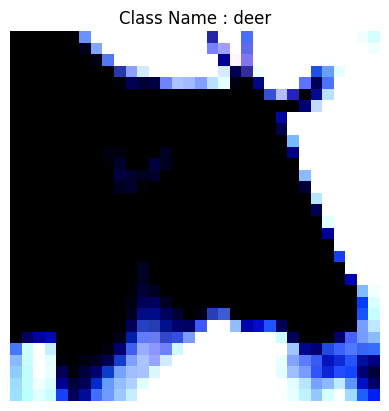

In [6]:
image_batch, label_batch = next(iter(train_dataloader))
class_names = training_data.classes

plt.imshow(image_batch[0].permute(1, 2, 0))
plt.title(f"Class Name : {class_names[label_batch[0]]}")
plt.axis("off")
plt.show()

## Creating Our Custom CNN Module

In [7]:
class SimpleCIFAR10(nn.Module):
  def __init__(self, in_channels:int,base_channels: int, out_channels:int ):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=base_channels, kernel_size=3, stride=1),
        nn.BatchNorm2d(num_features=base_channels),
        nn.ReLU(),
        nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(base_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3))

    self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))
    self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

    # Calculate flattened size dynamically for 32x32 input
    dummy_input = torch.randn(1, in_channels, 32, 32)
    with torch.no_grad():
        x = self.conv_layer_1(dummy_input)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
    flattened_size = x.numel()
    print(f"Calculated flattened size for nn.Linear: {flattened_size}\n") # This will change based on base_channels

    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=512),
            nn.BatchNorm1d(512), # BatchNorm for linear layers
            nn.ReLU(),
            nn.Dropout(0.6), # Higher dropout for linear layer
            nn.Linear(in_features=512, out_features=out_channels)
        )
  def forward(self, x):
      x = self.conv_layer_1(x)
      x = self.conv_layer_2(x)
      x = self.conv_layer_3(x)
      return self.classifier(x)

model = SimpleCIFAR10(3, 64, 10) # -> (Color_Channels, Base_Channels, Num_Classes)
model.to(DEVICE)
# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Num parameters : {count_parameters(model)}")

Calculated flattened size for nn.Linear: 2304

Num parameters : 2333514


## Create Train and Test Functions

In [12]:
def train_step(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.0
    correct = 0

    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)


        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = running_loss / len(dataloader)
    acc = correct / size
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {100 * acc:.2f}%")
    return avg_loss, acc


In [13]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = test_loss / len(dataloader)
    acc = correct / size
    print(f"Val Loss: {avg_loss:.4f}, Accuracy: {100 * acc:.2f}%")
    return avg_loss, acc


## Specify Our Loss Function and Optimizer

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6) # eta_min is min LR

## Training Our Model

Epoch 1
---------------------------------------
Train Loss: 1.1247, Accuracy: 59.09%
Val Loss: 1.0168, Accuracy: 63.28%
✅ Best model saved! Accuracy: 0.63
Epoch 2
---------------------------------------
Train Loss: 0.9302, Accuracy: 66.87%
Val Loss: 0.8356, Accuracy: 70.08%
✅ Best model saved! Accuracy: 0.70
Epoch 3
---------------------------------------
Train Loss: 0.8421, Accuracy: 70.07%
Val Loss: 0.9204, Accuracy: 66.92%
Epoch 4
---------------------------------------
Train Loss: 0.7793, Accuracy: 72.41%
Val Loss: 0.7226, Accuracy: 74.30%
✅ Best model saved! Accuracy: 0.74
Epoch 5
---------------------------------------
Train Loss: 0.7297, Accuracy: 74.03%
Val Loss: 0.6873, Accuracy: 76.18%
✅ Best model saved! Accuracy: 0.76
Epoch 6
---------------------------------------
Train Loss: 0.6884, Accuracy: 75.74%
Val Loss: 0.6368, Accuracy: 77.74%
✅ Best model saved! Accuracy: 0.78
Epoch 7
---------------------------------------
Train Loss: 0.6484, Accuracy: 77.29%
Val Loss: 0.6093, Ac

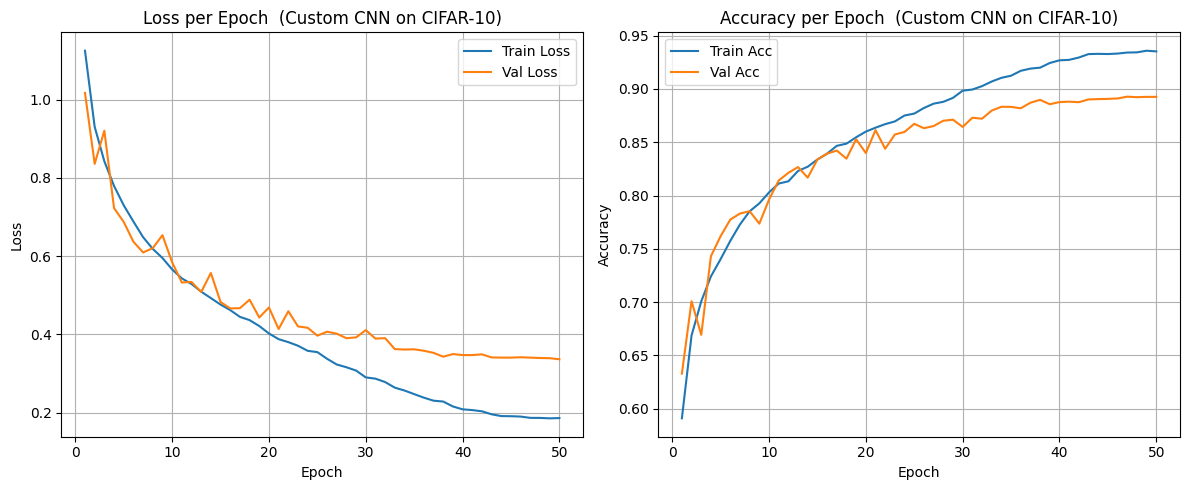

In [15]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

best_val_acc = 0.0
for t in range(epochs):
    print(f"Epoch {t+1}\n---------------------------------------")
    train_loss, train_acc = train_step(train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer)
    val_loss, val_acc = test_loop(test_dataloader, model=model, loss_fn=loss_fn)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Best model saved! Accuracy: {best_val_acc:.2f}")

    scheduler.step()

plot_metrics(history, title_suffix=" (Custom CNN on CIFAR-10)")